In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 2
setup_one_gpu(GPU)

Picking GPU 2


In [49]:
import sys
import numpy as np
import os.path as osp
import tensorflow as tf
import glob
import matplotlib.pylab as plt

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf


from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id
from tf_lab.autopredictors.scripts.virt_scan_data import plotting_default_params


from general_tools.notebook.tf import reset_tf_graph                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k, indices_in_iterable


from geo_tool import Point_Cloud

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader

from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs

from tf_lab.nips.evaluate_gan import entropy_of_occupancy_grid, point_cloud_distances

from general_tools.strings import trim_content_after_last_dot

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
n_pc_samples = 2048
seed = 42
np.random.seed(seed)

In [10]:
# LOAD (Synthetic) Point-Cloud Data
in_f = '/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/our_samples/gt_all_chair.npz'
syn_data = np.load(in_f)
syn_data = syn_data[syn_data.keys()[0]]

In [17]:
session = tf.Session()
distance_type = 'EMD'
all_dists = point_cloud_distances(syn_data, 10, session, distance_type)

302.428


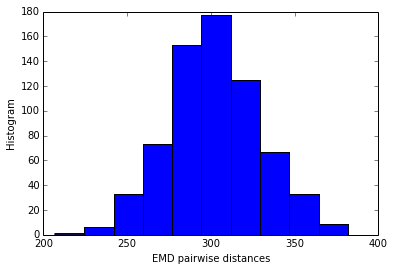

In [51]:
print np.mean(all_dists)
plt.hist(all_dists)[2]
plt.xlabel(distance_type + ' pairwise distances')
plt.ylabel('Histogram')
plt.savefig(trim_content_after_last_dot(in_f) + '_dist_hist.png')

In [52]:
assert(abs(np.min(syn_data)) <= 0.5 and abs(np.max(syn_data)) <=0.5)
print entropy_of_occupancy_grid(syn_data, 32)

0.0742874735364


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


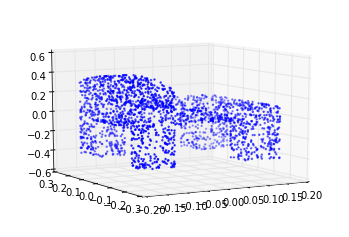

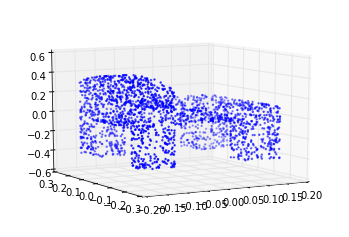

In [53]:
Point_Cloud(syn_data[0]).plot()